### Fisher Scoring Algorithm for Probit Regression

In [1]:
import numpy as np
import scipy.stats as stats
from scipy.stats import norm


def prob_f(p):
    return stats.norm.ppf(p)

def der_prob(p):
    return 1 / norm.pdf(norm.ppf(p))

def probit(X, Y, epsilon):
# X = covariates
# Y = dependent variable
# epsilon = threshold for convergence

    n,p = np.shape(X)
    
    b_0 = np.zeros((p,1))
    mu = norm.cdf(np.dot(X,b_0))
    W = np.diag((((1/(mu*(1-mu)))*(der_prob(mu)**-2)).reshape(n,)))
    Z = np.dot(X,b_0)+(Y-mu)*der_prob(mu)
    i = 0
    

    convergence = False
    while not convergence:
        i += 1
        
        b = np.linalg.multi_dot([np.linalg.inv(np.linalg.multi_dot([X.T, W, X])), X.T,W, Z])
        mu = norm.cdf(np.dot(X,b))
        W = np.diag((((1/(mu*(1-mu)))*(der_prob(mu)**-2)).reshape(n,)))
        Z = np.dot(X,b)+(Y-mu)*der_prob(mu)

        if np.linalg.norm(b-b_0)/(np.linalg.norm(b_0)+epsilon) < epsilon: #relative convergence criterion
            convergence = True
            print("\nConvergence reached with value:",np.linalg.norm(b-b_0)/(np.linalg.norm(b_0)+epsilon))
            print('Number of Iterations: ' + str(i) + '\n')
        b_0 = b
    
    return(b)






import pandas as pd
import numpy as np


df = pd.read_csv('SAheart.txt', delimiter=' ')
df['famhist'] = df['famhist'].replace({'Absent': 0, 'Present': 1})

X = df.iloc[:, :-1].values
Y = df.iloc[:, -1].values.reshape((-1, 1))
X = np.hstack((np.ones((X.shape[0], 1)), X)) # Adding a column of ones for the intercept


beta_results = probit(X, Y, epsilon=0.000001)
c = ['Intercept'] + list(df.columns)
for i in range(len(beta_results)):
    print(c[i], (len('Intercept')-len(c[i]))*' ', '\t', beta_results[i][0])


Convergence reached with value: 7.091230857565079e-08
Number of Iterations: 7

Intercept  	 -3.57018427597999
sbp        	 0.0037893560137235516
tobacco    	 0.04821980993418297
ldl        	 0.10282886285269183
adiposity  	 0.012395659250210467
famhist    	 0.5389790001888821
typea      	 0.02355574727587298
obesity    	 -0.04016208235183405
alcohol    	 1.9557237787003537e-05
age        	 0.026269408776200404


In [2]:
# Comparison with a pre-existing library
import statsmodels.api as smf
smf.Probit(Y,X).fit().summary2()

Optimization terminated successfully.
         Current function value: 0.510740
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Probit
=================================================================
Model:              Probit           Pseudo R-squared: 0.208     
Dependent Variable: y                AIC:              491.9241  
Date:               2024-01-12 15:24 BIC:              533.2797  
No. Observations:   462              Log-Likelihood:   -235.96   
Df Model:           9                LL-Null:          -298.05   
Df Residuals:       452              LLR p-value:      1.8555e-22
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const     -3.5702     0.7489   -4.7669   0.0000   -5.0381   -2.1023
x1         0.0038     0.0034    1.1043   0.2695   -0.0029    0.0105
x2         0.0482     0.0159    3.0236   0.0025    0.0170    0.0795
x3         0.1028     0.0352    2.9237   0.0035    0.0339    0.1718
x4         0.0124     0.0174    0.7136   0.4755   -0.0216    0.0464
x5         0.5390     0.1352    3.9862   0.0001    0.2740    0.8040
x6         0.0236     0.0072    3.2653   0.0011    0.0094    0.0377
x7        -0.0402     0.0260   -1.5477   0.1217   -0.0910    0.0107
x8         0.0000     0.0027    0.0073   0.9942   -0.0053    0.0053
x9         0.0263     0.0071    3.7182   0.0002    0.0124    0.0401
=================================================================

"""

### Random Walk Metropolis-Hastings for a Bayesian Probit Regression

Acceptance Rate: 0.39645 

Mean of intercept: 	-3.5486053271180826
Mean of sbp:        	0.003686252158048188
Mean of tobacco:    	0.04718316595196746
Mean of ldl:        	0.07003260682155014
Mean of adiposity:  	0.022272275836570283
Mean of famhist:    	0.6308297874508321
Mean of typea:      	0.023933928930456143
Mean of obesity:    	-0.04393273232281226
Mean of alcohol:    	-6.538539858707895e-05
Mean of age:        	0.024832054721043786


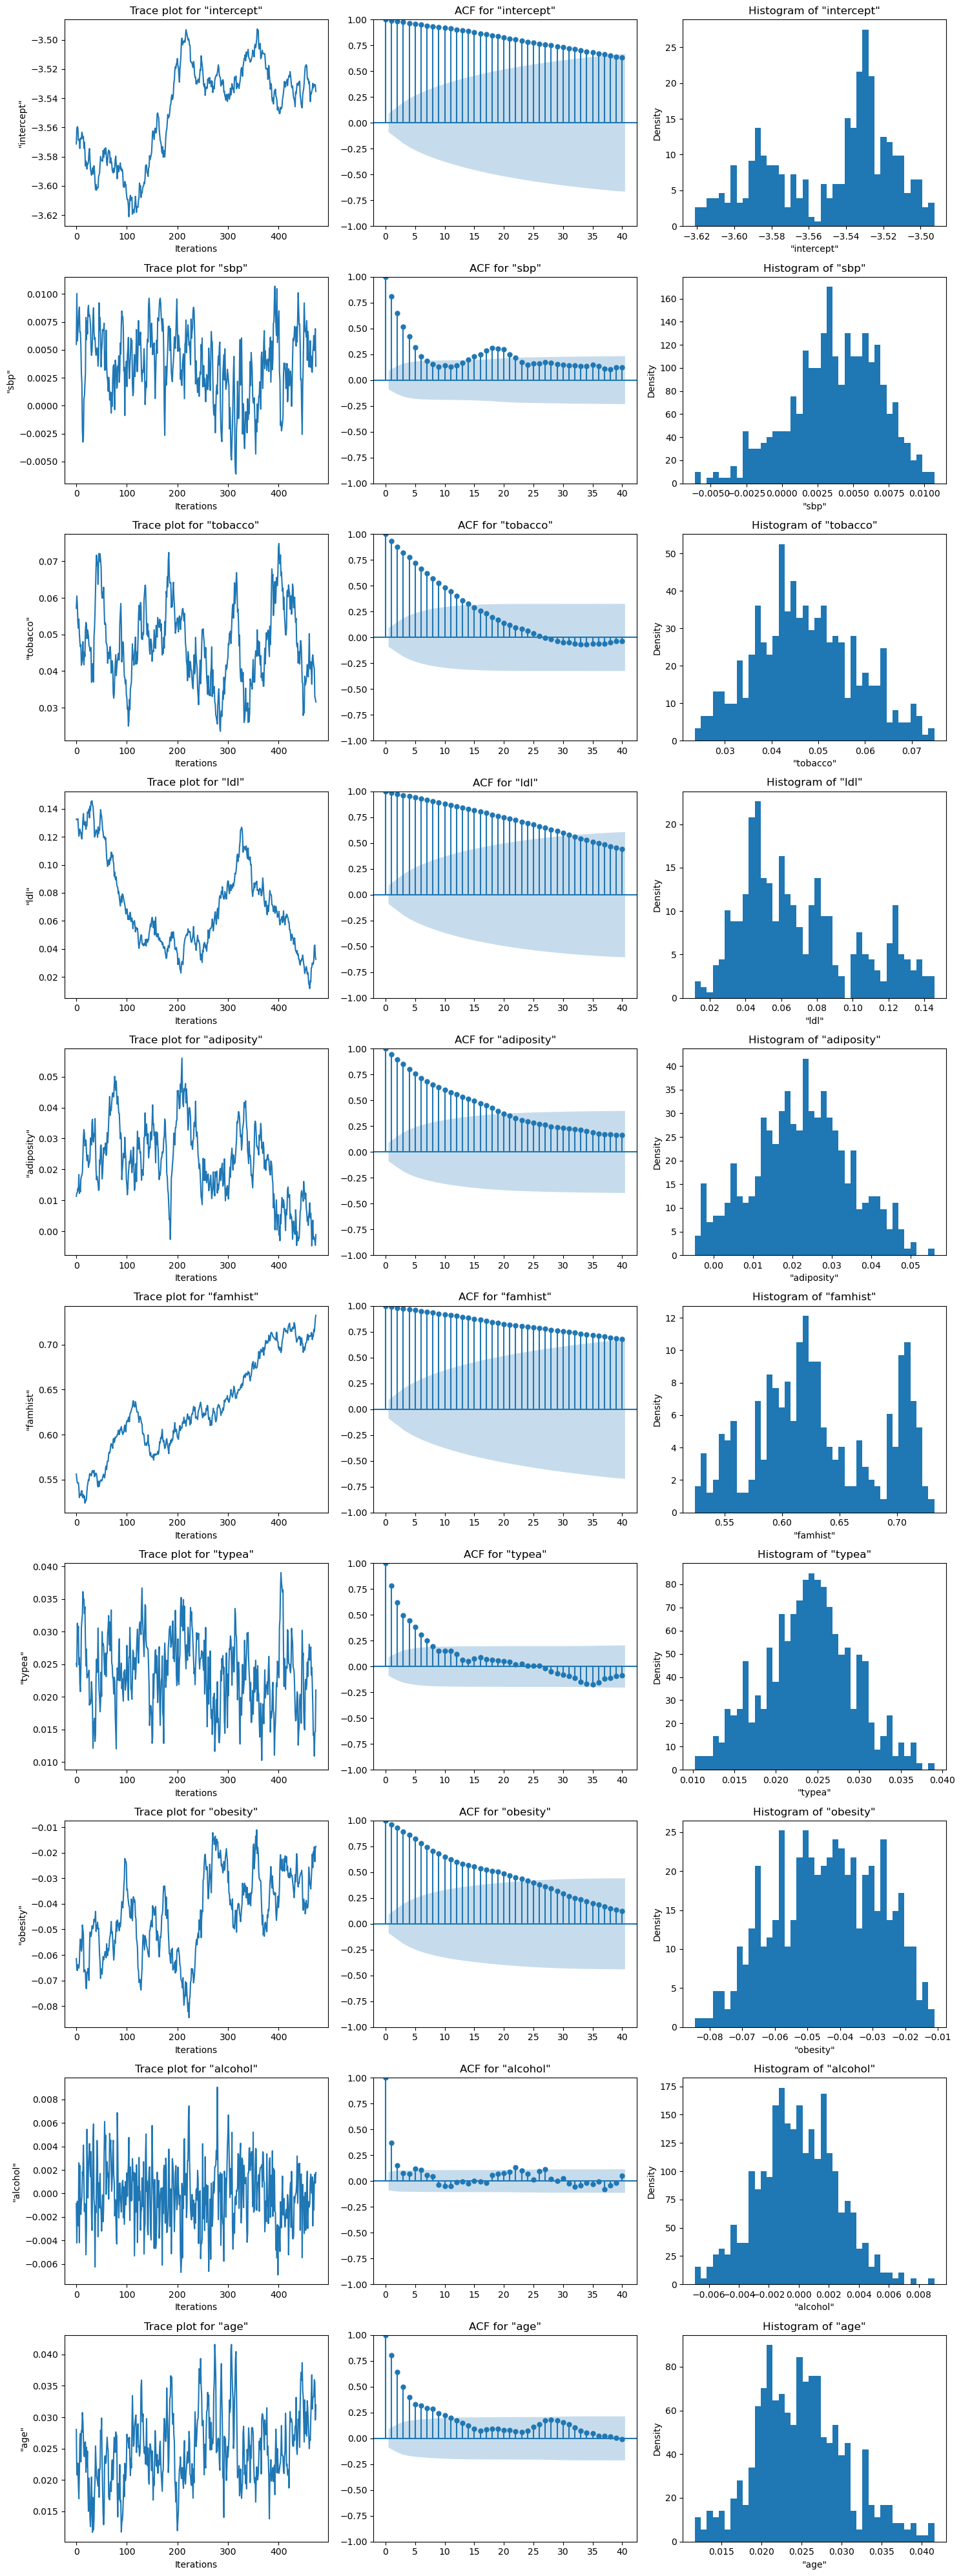

In [3]:
import numpy as np
from scipy.stats import norm
import pandas as pd
np.random.seed(0)


def probit(X, beta):
    return norm.cdf(np.dot(X, beta))

def probit_likelihood(beta, X, y):
    p = probit(X, beta)
    likelihood = np.prod(np.where(y == 1, p, 1 - p))
    return likelihood


df = pd.read_csv('SAheart.txt', delimiter=' ')
df['famhist'] = df['famhist'].replace({'Absent': 0, 'Present': 1})
df.head()

X = df.drop('chd', axis=1).values
X = np.hstack([np.ones((X.shape[0], 1)), X])  # Column of ones added for the intercept
y = df['chd'].values


num_iterations = 20000
num_covariates = 10  # 9 covariates + intercept

# Starting values based on the Fisher-scoring results
beta = np.array([-3.57018427597999,
                 0.0037893560137235516, 0.04821980993418297, 0.10282886285269183,
                 0.012395659250210467, 0.5389790001888821, 0.02355574727587298,
                 -0.04016208235183405, 0.000019557237787003537, 0.026269408776200404])

proposal_std = 0.000001
samples = np.zeros((num_iterations, num_covariates))
accepted = 0


# Metropolis-Hastings
for i in range(num_iterations):
    beta_proposal = np.random.multivariate_normal(beta, np.eye(num_covariates) * proposal_std)
    
    likelihood_current = probit_likelihood(beta, X, y)
    likelihood_proposal = probit_likelihood(beta_proposal, X, y)
    acceptance_ratio = min(1, likelihood_proposal / likelihood_current)
    
    if np.random.uniform(size = 1) <= acceptance_ratio:
        beta = beta_proposal
        accepted += 1
    
    samples[i, :] = beta

acceptance_rate = accepted / num_iterations
print('Acceptance Rate:', acceptance_rate, '\n')








### RESULTS

import matplotlib.pyplot as plt
import statsmodels.api as sm


burn_in = int(num_iterations * 0.05)
samples = samples[burn_in:, :]
mean_coefficients = np.mean(samples, axis=0)


print(f'Mean of intercept: \t{mean_coefficients[0]}')
for j in range(1, num_covariates):
    print(f'Mean of {df.columns[j-1]}:',
          (len('intercept') - len(df.columns[j-1]))*' ',
          f'\t{mean_coefficients[j]}')


num_rows = num_covariates
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4 * num_rows))
samples = samples[::40] # thinning
columns = ['intercept'] + list(df.columns)

for j in range(num_covariates):
    # Trace plots
    axes[j, 0].plot(samples[:, j])
    axes[j, 0].set_title(f'Trace plot for "{columns[j]}"')
    axes[j, 0].set_xlabel('Iterations')
    axes[j, 0].set_ylabel(f'"{columns[j]}"')
    # ACF plots
    sm.graphics.tsa.plot_acf(samples[:, j], lags=40, ax=axes[j, 1])
    axes[j, 1].set_title(f'ACF for "{columns[j]}"')
    # Histograms
    axes[j, 2].hist(samples[:, j], bins=40, density=True)
    axes[j, 2].set_title(f'Histogram of "{columns[j]}"')
    axes[j, 2].set_xlabel(f'"{columns[j]}"')
    axes[j, 2].set_ylabel('Density')

plt.tight_layout()
plt.show()

### Comparison Between the Two Algorithms

In [4]:
data = {
    'Coefficient': ['intercept'] + [f'{col}' for col in df.columns[:-1]],
    'Metropolis-Hastings': [mean_coefficients[i] for i in range(num_covariates)],
    'Fisher Scoring': [beta_results[i][0] for i in range(num_covariates)]
}

pd.DataFrame(data)

,Coefficient,Metropolis-Hastings,Fisher Scoring
0,intercept,-3.548605,-3.570184
1,sbp,0.003686,0.003789
2,tobacco,0.047183,0.048220
3,ldl,0.070033,0.102829
4,adiposity,0.022272,0.012396
5,famhist,0.630830,0.538979
6,typea,0.023934,0.023556
7,obesity,-0.043933,-0.040162
8,alcohol,-0.000065,0.000020
9,age,0.024832,0.026269
